## Part 1: Exploratory Data Analysis

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [96]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import datetime

1. Load data

In [97]:
categories=pd.read_csv('item_categories.csv')
items=pd.read_csv('items.csv')
train=pd.read_csv('sales_train.csv')
sample=pd.read_csv('sample_submission.csv')
shops=pd.read_csv('shops.csv')
test=pd.read_csv('test.csv')

In [98]:
categories.head()
categories['item_category_name'].nunique()
categories.describe()
categories
# each category matches for one id but it seems there are duplicated category names 

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [99]:
items.head()
items.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [100]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [101]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [102]:
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


The final submission file should group sales by month but the test file only provides shop id and item id. In this case, we need to explore ship info and item info and then finally group them in month.

2. Outliers and negative values

In [9]:
train.head()
train['item_price'].describe()
train['item_cnt_day'].describe()
# There are negative values for both item price and item daily sales.
# The negative values for item daily sales may stand for returned items. 
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [10]:
train[train['item_price']<0]
# Only one record, no big deal.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [11]:
train[train['item_cnt_day']<0]
# There are 7356 out of 2935849 lines of records that are negative values. 

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0
...,...,...,...,...,...,...
2934243,26.10.2015,33,25,3917,449.0,-1.0
2934462,18.10.2015,33,25,4896,6398.0,-1.0
2935263,05.10.2015,33,25,10039,249.0,-1.0
2935643,16.10.2015,33,25,7893,2990.0,-1.0


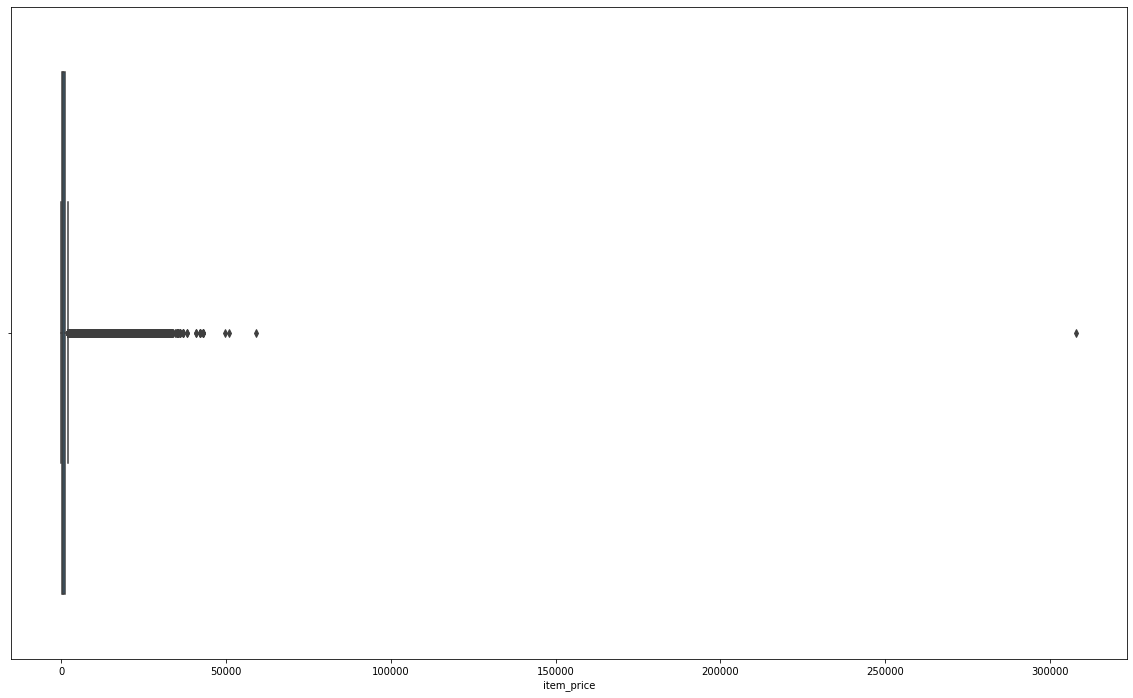

In [12]:
plt.figure(figsize=(20,12))
sns.boxplot(data=train, x='item_price')
# Exclude values bigger than 10000 and smaller than 0.

In [13]:
print(len(train[train['item_price']>300000]))
print(len(train[train['item_price']>50000]))
print(len(train[train['item_price']>10000]))

1
3
19745


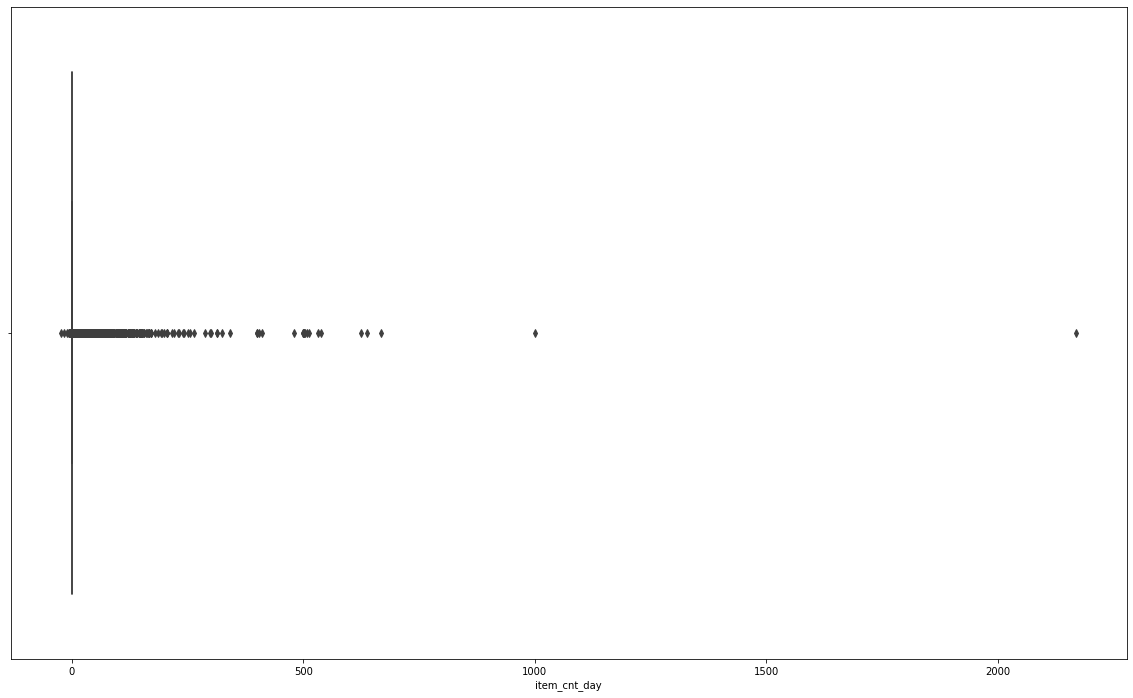

In [14]:
plt.figure(figsize=(20,12))
sns.boxplot(data=train, x='item_cnt_day')
# Exclude values bigger than 1000 and smaller than 0.

In [15]:
print(len(train[train['item_cnt_day']>2000]))
print(len(train[train['item_cnt_day']>1000]))
print(len(train[train['item_cnt_day']>500]))

1
1
12


In [16]:
train=train[train['item_price']<40000]
train=train[train['item_price']>0]
train=train[train['item_cnt_day']<500]
train=train[train['item_cnt_day']>0]

In [17]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [18]:
duplicates=train.duplicated().reset_index()
duplicates.rename(columns={'0':'duplicates'})
duplicates
train[train.duplicated()]
# Only six duplicated rows, no big deal

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


3. Look into trend of montnly sales

In [19]:
# Group data by item_id
train_groupby_item=train.pivot_table(index=['item_id'], values=['item_cnt_day'],columns='date_block_num',aggfunc=np.sum,fill_value=0).reset_index()

In [20]:
train_groupby_item

item_id item_cnt_day                           ...              \
date_block_num                    0  1  2  3  4  5  6  7   8  ...  24  25  26   
0                    0            0  0  0  0  0  0  0  0   0  ...   0   0   0   
1                    1            0  0  0  0  0  0  0  0   0  ...   0   0   0   
2                    2            0  0  0  0  0  0  0  0   0  ...   0   0   0   
3                    3            0  0  0  0  0  0  0  0   0  ...   0   0   0   
4                    4            0  0  0  0  0  0  0  0   0  ...   0   0   0   
...                ...          ... .. .. .. .. .. .. ..  ..  ...  ..  ..  ..   
21794            22165            0  0  0  0  0  0  0  1   0  ...   0   0   0   
21795            22166            0  0  0  0  0  0  0  0   0  ...   7   8  12   
21796            22167            0  0  0  0  0  0  0  0  56  ...  33  46  40   
21797            22168            2  2  1  0  0  0  0  0   1  ...   0   0   0   
21798            22169            0  0  0  0  0  0  0  0   0  ...   0   0   0   

                                            
date_block_num  27  28  29  30  31  32  33  
0                0   0   0   0   0   0   0  
1                0   0   0   0   0   0   0  
2                0   0   0   0   0   0   0  
3                0   0   0   0   0   0   0  
4                0   0   0   0   0   0   0  
...             ..  ..  ..  ..  ..  ..  ..  
21794            0   0   0   0   0   0   0  
21795            4   8  10   8  11   5  11  
21796           38  32  33  34  29  21  37  
21797            0   0   0   0   0   0   0  
21798            0   0   0   0   0   0   0  

[21799 rows x 35 columns]

In [21]:
train_groupby_item.columns=train_groupby_item.columns.droplevel().map(str)

In [22]:
train_groupby_item=train_groupby_item.reset_index(drop=True).rename_axis(None,axis=1)

In [23]:
train_groupby_item.columns.values[0]='item_id'

In [24]:
train_groupby_item

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21794,22165,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
21795,22166,0,0,0,0,0,0,0,0,0,...,7,8,12,4,8,10,8,11,5,11
21796,22167,0,0,0,0,0,0,0,0,56,...,33,46,40,38,32,33,34,29,21,37
21797,22168,2,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


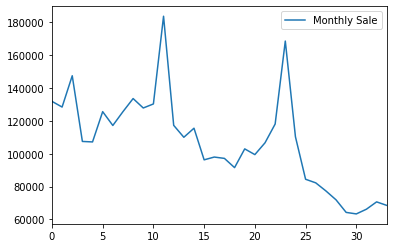

In [25]:
# Plot monthly sale(index>=1)
train_groupby_item.sum()[1:].plot(legend=True,label="Monthly Sale")

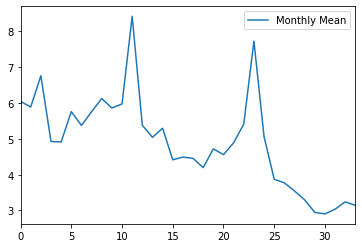

In [26]:
# Plot monthly mean
train_groupby_item.mean()[1:].plot(legend=True,label="Monthly Mean")

In [27]:
# Look into the outdated products(27-33th month with no sale)
outdated_items=train_groupby_item[train_groupby_item.loc[:,'27':].sum(axis=1)==0]

In [28]:
outdated_items=outdated_items.reset_index()
#There are 12347 outdated products in train set

In [29]:
# How many outdated items are overlapped in test dataset
print("outdated_items in test dataset:", len(test[test['item_id'].isin(outdated_items['item_id'])]))
# There are 6972 outdated items in test dataset.

outdated_items in test dataset: 6888


In [30]:
# Look into sales group by shop id in train data set
train_groupby_shop=train.pivot_table(index=['shop_id'], values=['item_cnt_day'], columns='date_block_num',aggfunc=np.sum, fill_value=0).reset_index()

In [31]:
train_groupby_shop.columns=train_groupby_shop.columns.droplevel().map(str)

In [32]:
train_groupby_shop=train_groupby_shop.reset_index(drop=True).rename_axis(None, axis=1)

In [33]:
train_groupby_shop.columns.values[0]='shop_id'

In [34]:
train_groupby_shop

,shop_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,5578,6127,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2947,3364,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1151,489,756,585,553,832,809,878,949,...,989,916,766,862,846,807,789,943,825,727
3,3,767,801,959,648,718,789,729,891,1031,...,982,739,747,741,734,676,542,668,749,615
4,4,2117,2036,2069,287,1212,1465,1384,1718,1536,...,1192,981,981,902,896,797,844,948,734,831
5,5,0,879,1357,1008,1111,1395,1269,1514,1299,...,1408,1102,1111,1057,1013,955,994,1297,1098,1054
6,6,3699,4017,4528,3174,3027,3853,3368,3709,4222,...,2336,2334,1985,2001,1758,1546,1487,1576,1728,1803
7,7,2498,2516,2464,1541,1648,2089,2032,2399,2600,...,2085,1850,1433,1340,1219,1238,1327,1411,1292,1216
8,8,1463,1156,983,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3188


In [35]:
# Look into the newly opened for each month
for i in range(0,34):
    print('Not exits in month', i ,train_groupby_shop['shop_id'][train_groupby_shop.loc[:,'0':str(i)].sum(axis=1)==0].unique())
# The most recently opened shop is the shop 36.
# There might be sale events when the shop is newly opened.We might need to label thoes newly opened shops in each month.

Not exits in month 0 [ 5  9 11 17 20 33 34 36 39 40 48 49 55 57 58]
Not exits in month 1 [ 9 11 17 20 33 34 36 39 40 48 49 55 57 58]
Not exits in month 2 [ 9 11 17 20 33 34 36 39 40 48 49 55]
Not exits in month 3 [ 9 11 17 20 33 34 36 39 40 48 49 55]
Not exits in month 4 [ 9 11 17 20 33 34 36 39 40 48 49]
Not exits in month 5 [ 9 11 20 33 34 36 39 40 48 49]
Not exits in month 6 [ 9 11 20 33 34 36 39 40 48 49]
Not exits in month 7 [ 9 11 20 33 34 36 39 40 48 49]
Not exits in month 8 [ 9 11 20 33 34 36 39 40 48 49]
Not exits in month 9 [11 20 33 34 36 39 40 48 49]
Not exits in month 10 [11 20 33 34 36 39 40 48 49]
Not exits in month 11 [11 20 33 34 36 39 40 48]
Not exits in month 12 [11 20 33 34 36 39 40 48]
Not exits in month 13 [11 20 33 34 36 39 40 48]
Not exits in month 14 [11 20 33 34 36 48]
Not exits in month 15 [11 20 33 34 36]
Not exits in month 16 [11 20 33 34 36]
Not exits in month 17 [11 20 33 34 36]
Not exits in month 18 [11 20 33 36]
Not exits in month 19 [11 20 36]
Not exit

In [36]:
# Look into the outdated shops
for i in range(0,28):
    print('Shop is outdated for month',i, train_groupby_shop['shop_id'][train_groupby_shop.loc[:,str(i):].sum(axis=1)==0].unique())
    
# As closing and opening month are both sepcial shop events, we might need to label thoes info for possible features.

Shop is outdated for month 0 []
Shop is outdated for month 1 []
Shop is outdated for month 2 [0 1]
Shop is outdated for month 3 [0 1 8]
Shop is outdated for month 4 [ 0  1  8 23]
Shop is outdated for month 5 [ 0  1  8 23]
Shop is outdated for month 6 [ 0  1  8 23]
Shop is outdated for month 7 [ 0  1  8 23 32]
Shop is outdated for month 8 [ 0  1  8 23 32]
Shop is outdated for month 9 [ 0  1  8 23 32]
Shop is outdated for month 10 [ 0  1  8 23 32]
Shop is outdated for month 11 [ 0  1  8 23 32]
Shop is outdated for month 12 [ 0  1  8 23 32]
Shop is outdated for month 13 [ 0  1  8 23 32]
Shop is outdated for month 14 [ 0  1  8 23 32]
Shop is outdated for month 15 [ 0  1  8 23 32]
Shop is outdated for month 16 [ 0  1  8 23 32]
Shop is outdated for month 17 [ 0  1  8 23 32]
Shop is outdated for month 18 [ 0  1  8 23 32]
Shop is outdated for month 19 [ 0  1  8 23 32]
Shop is outdated for month 20 [ 0  1  8 13 23 32]
Shop is outdated for month 21 [ 0  1  8 13 23 32]
Shop is outdated for month 

4. Look into the shop info and category info

In [37]:
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

,shop_name,shop_id,shop_city,shop_type
0,якутск орджоникидзе фран,0,якутск,NO_DATA
1,якутск тц центральный фран,1,якутск,тц
2,адыгея тц мега,2,адыгея,тц
3,балашиха трк октябрькиномир,3,балашиха,трк
4,волжский тц волга молл,4,волжский,тц


In [38]:
from sklearn import preprocessing

shop_city_la=preprocessing.LabelEncoder()
shop_city_la.fit(shops['shop_city'])
city_labels=shop_city_la.transform(shops['shop_city'])
shops['shop_city_labeled']=city_labels

shop_type_la=preprocessing.LabelEncoder()
shop_type_la.fit(shops['shop_type'])
type_labels=shop_type_la.transform(shops['shop_type'])
shops['shop_type_labeled']=type_labels

#shops

In [39]:
cat_type_la=preprocessing.LabelEncoder()
categories['split'] = categories['item_category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x: x[0].strip())
cat_type_la.fit(categories['type'])
cat_type_labels=cat_type_la.transform(categories['type'])
categories['type_code'] = cat_type_labels

cat_subtype_la=preprocessing.LabelEncoder()
categories['subtype'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cat_subtype_la.fit(categories['subtype'])
cat_subtype_labels=cat_subtype_la.transform(categories['subtype'])
categories['subtype_code'] = cat_subtype_labels

In [40]:
categories

,item_category_name,item_category_id,split,type,type_code,subtype,subtype_code
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,0,Гарнитуры/Наушники,29
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,1,PS2,9
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,1,PS3,10
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,1,PS4,11
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,1,PSP,13
...,...,...,...,...,...,...,...
79,Служебные,79,[Служебные],Служебные,16,Служебные,54
80,Служебные - Билеты,80,"[Служебные , Билеты]",Служебные,16,Билеты,25
81,Чистые носители (шпиль),81,[Чистые носители (шпиль)],Чистые носители (шпиль),17,Чистые носители (шпиль),62
82,Чистые носители (штучные),82,[Чистые носители (штучные)],Чистые носители (штучные),18,Чистые носители (штучные),63


5. Look into pairs of test data set and train data set

In [41]:
# We need to apply different methods to do predictions

good_sales = test.merge(train, on=['item_id','shop_id'], how='left').dropna()
good_pairs = test[test['ID'].isin(good_sales['ID'])]
no_data_items = test[~(test['item_id'].isin(train['item_id']))]

print('1. Number of good pairs:', len(good_pairs))
print('2. No Data Items:', len(no_data_items))
print('3. Only Item_id Info:', len(test)-len(no_data_items)-len(good_pairs))

1. Number of good pairs: 111397
2. No Data Items: 15246
3. Only Item_id Info: 87557


In [42]:
# Several shops are duplicates of each other (according to its name). Fix train and test set.

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

6. look into dates

In [43]:
import datetime

In [44]:
train['date']=train['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [45]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928464 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 156.4 MB
None


In [46]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0


In [47]:
# weekend and holiday sales
train['day']=train['date'].apply(lambda x:x.weekday())

In [48]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day
0,2013-01-02,0,59,22154,999.00,1.0,2
1,2013-01-03,0,25,2552,899.00,1.0,3
3,2013-01-06,0,25,2554,1709.05,1.0,6
4,2013-01-15,0,25,2555,1099.00,1.0,1
5,2013-01-10,0,25,2564,349.00,1.0,3
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,5
2935845,2015-10-09,33,25,7460,299.00,1.0,4
2935846,2015-10-14,33,25,7459,349.00,1.0,2
2935847,2015-10-22,33,25,7440,299.00,1.0,3


In [49]:
# groupby day of the week
train.groupby('day')['item_cnt_day'].sum().reset_index()
# Obviously, weekends have more volumn of sales.

,day,item_cnt_day
0,0,402688.0
1,1,453444.0
2,2,436736.0
3,3,453701.0
4,4,554050.0
5,5,735121.0
6,6,610294.0


7. Summary of EDA and potential features

According to the EDA, it is better to add additional features including:
1. shop ciy and shop type in shop info
2. the closing month and opening month of each shop
3. the day of the week according to date in train data set
4. label the good pairs in both train and test sets and thoes only in test data sets

## Part 2: Data Preprocessing

2. Clean data (exclude outliers)

In [50]:
# group by month
train_groupby_month=train.sort_values('date').groupby(['date_block_num','shop_id','item_id'],as_index=False)

In [51]:
train_groupby_agg=train_groupby_month.agg({'item_cnt_day':['sum'],'item_price':['sum']})

In [52]:
train_groupby_agg

,date_block_num,shop_id,item_id,item_cnt_day,item_price
,,,,sum,sum
0,0,2,27,1.0,2499.0
1,0,2,33,1.0,499.0
2,0,2,317,1.0,299.0
3,0,2,438,1.0,299.0
4,0,2,471,2.0,798.0
...,...,...,...,...,...
1608207,33,59,22087,6.0,357.0
1608208,33,59,22088,2.0,238.0
1608209,33,59,22091,1.0,179.0


In [53]:
train_groupby_agg.columns=['date_block_num','shop_id','item_id','item_sum_cnt','revenue']

In [54]:
train_groupby_agg

,date_block_num,shop_id,item_id,item_sum_cnt,revenue
0,0,2,27,1.0,2499.0
1,0,2,33,1.0,499.0
2,0,2,317,1.0,299.0
3,0,2,438,1.0,299.0
4,0,2,471,2.0,798.0
...,...,...,...,...,...
1608207,33,59,22087,6.0,357.0
1608208,33,59,22088,2.0,238.0
1608209,33,59,22091,1.0,179.0
1608210,33,59,22100,1.0,629.0


3. Join data

In [55]:
test['date_block_num']=34

In [56]:
train_test=pd.concat([test,train_groupby_agg],ignore_index=True,sort=False)

In [57]:
train_test['ID']=train_test['ID'].fillna(1000000)

In [58]:
train_test['item_sum_cnt']=train_test['item_sum_cnt'].fillna(0)

In [59]:
train_test['revenue']=train_test['revenue'].fillna(0)

In [60]:
All_join=train_test.join(items,on='item_id',rsuffix='_').join(categories,on='item_category_id',rsuffix='_').join(shops,on='shop_id',rsuffix='_').drop(['item_id_','shop_id_','item_category_id_'],axis=1)
All_join.columns
All_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,type,type_code,subtype,subtype_code,shop_name,shop_city,shop_type,shop_city_labeled,shop_type_labeled
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",Музыка,13,CD локального производства,2,вологда трц мармелад,вологда,трц,3,4
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",Игры,5,PS3,10,вологда трц мармелад,вологда,трц,3,4
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",Игры,5,XBOX 360,16,вологда трц мармелад,вологда,трц,3,4
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",Игры,5,PS4,11,вологда трц мармелад,вологда,трц,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822407,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
1822408,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
1822409,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],Элементы питания,19,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5
1822410,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",Книги,12,"Артбуки, энциклопедии",19,ярославль тц альтаир,ярославль,тц,30,5


In [61]:
All_join['item_sum_cnt']=All_join['item_sum_cnt'].clip(0,20)

In [62]:
# Add mean encoded features

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [63]:
group = All_join.groupby(['date_block_num']).agg({'item_sum_cnt': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

All_join = pd.merge(All_join, group, on=['date_block_num'], how='left')
All_join['date_avg_item_cnt'] = All_join['date_avg_item_cnt'].astype(np.float16)
All_join = lag_feature(All_join, [1,2,3], 'date_avg_item_cnt')
All_join.drop(['date_avg_item_cnt'], axis=1, inplace=True)

In [64]:
group = All_join.groupby(['date_block_num','item_id']).agg({'item_sum_cnt': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

All_join = pd.merge(All_join, group, on=['date_block_num'], how='left')
All_join['date_item_avg_item_cnt'] = All_join['date_item_avg_item_cnt'].astype(np.float16)
All_join = lag_feature(All_join, [1,2,3], 'date_item_avg_item_cnt')
All_join.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

In [65]:
group = All_join.groupby(['date_block_num','item_id','shop_id']).agg({'item_sum_cnt': ['mean']})
group.columns = [ 'date_shop_item_avg_item_cnt' ]
group.reset_index(inplace=True)

All_join = pd.merge(All_join, group, on=['date_block_num'], how='left')
All_join['date_shop_item_avg_item_cnt'] = All_join['date_shop_item_avg_item_cnt'].astype(np.float16)
All_join = lag_feature(All_join, [1,2,3], 'date_shop_item_avg_item_cnt')
All_join.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)

In [66]:
group = All_join.groupby(['date_block_num','shop_id']).agg({'item_sum_cnt': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

All_join = pd.merge(All_join, group, on=['date_block_num'], how='left')
All_join['date_shop_avg_item_cnt'] = All_join['date_shop_avg_item_cnt'].astype(np.float16)
All_join = lag_feature(All_join, [1,2,3], 'date_shop_avg_item_cnt')
All_join.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [ ]:
# Add trend feature



6. Prepare train and test set

## Part 3: Training

In [67]:
# normalize numeric variables
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
import datetime

In [68]:
# transform categorical values using one-hot encoding
from sklearn import preprocessing

In [70]:
# Considering time trend, add lagged feature
lag_list=[1,2,3]

for lag in lag_list:
    ft_name=('item_cnt_lagged%s' % lag)
    All_join[ft_name]=All_join.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_sum_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    All_join[ft_name].fillna(0, inplace=True)

In [71]:
All_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,subtype,subtype_code,shop_name,shop_city,shop_type,shop_city_labeled,shop_type_labeled,item_cnt_lagged1,item_cnt_lagged2,item_cnt_lagged3
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",...,PS3,10,вологда трц мармелад,вологда,трц,3,4,1.0,3.0,1.0
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",...,CD локального производства,2,вологда трц мармелад,вологда,трц,3,4,0.0,0.0,0.0
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",...,PS3,10,вологда трц мармелад,вологда,трц,3,4,1.0,3.0,1.0
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",...,XBOX 360,16,вологда трц мармелад,вологда,трц,3,4,1.0,0.0,0.0
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",...,PS4,11,вологда трц мармелад,вологда,трц,3,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822407,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5,3.0,2.0,5.0
1822408,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5,1.0,7.0,7.0
1822409,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],...,Элементы питания,64,ярославль тц альтаир,ярославль,тц,30,5,3.0,1.0,1.0
1822410,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",...,"Артбуки, энциклопедии",19,ярославль тц альтаир,ярославль,тц,30,5,1.0,0.0,0.0


In [72]:
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
# Add year and month
def convert(date_block):
    date = datetime.datetime(2013, 1, 1)
    date += relativedelta(months = date_block)
    return date


In [73]:
import datetime

datetime.datetime(2013,1,1)

datetime.datetime(2013, 1, 1, 0, 0)

In [74]:
All_join['year_month']=All_join['date_block_num'].apply(lambda x:convert(x))
All_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,subtype_code,shop_name,shop_city,shop_type,shop_city_labeled,shop_type_labeled,item_cnt_lagged1,item_cnt_lagged2,item_cnt_lagged3,year_month
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",...,10,вологда трц мармелад,вологда,трц,3,4,1.0,3.0,1.0,2015-11-01
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",...,2,вологда трц мармелад,вологда,трц,3,4,0.0,0.0,0.0,2015-11-01
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",...,10,вологда трц мармелад,вологда,трц,3,4,1.0,3.0,1.0,2015-11-01
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",...,16,вологда трц мармелад,вологда,трц,3,4,1.0,0.0,0.0,2015-11-01
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",...,11,вологда трц мармелад,вологда,трц,3,4,0.0,0.0,0.0,2015-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822407,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,64,ярославль тц альтаир,ярославль,тц,30,5,3.0,2.0,5.0,2015-10-01
1822408,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,64,ярославль тц альтаир,ярославль,тц,30,5,1.0,7.0,7.0,2015-10-01
1822409,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],...,64,ярославль тц альтаир,ярославль,тц,30,5,3.0,1.0,1.0,2015-10-01
1822410,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",...,19,ярославль тц альтаир,ярославль,тц,30,5,1.0,0.0,0.0,2015-10-01


In [75]:
All_join['Year']=All_join['year_month'].apply(lambda x:x.year)
All_join['Month']=All_join['year_month'].apply(lambda x:x.month)

In [76]:
All_join

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,shop_city,shop_type,shop_city_labeled,shop_type_labeled,item_cnt_lagged1,item_cnt_lagged2,item_cnt_lagged3,year_month,Year,Month
0,0.0,5,5037,34,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"[Игры , PS3]",...,вологда,трц,3,4,1.0,3.0,1.0,2015-11-01,2015,11
1,1.0,5,5320,34,0.0,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",...,вологда,трц,3,4,0.0,0.0,0.0,2015-11-01,2015,11
2,2.0,5,5233,34,0.0,0.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"[Игры , PS3]",...,вологда,трц,3,4,1.0,3.0,1.0,2015-11-01,2015,11
3,3.0,5,5232,34,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"[Игры , XBOX 360]",...,вологда,трц,3,4,1.0,0.0,0.0,2015-11-01,2015,11
4,4.0,5,5268,34,0.0,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"[Игры , PS4]",...,вологда,трц,3,4,0.0,0.0,0.0,2015-11-01,2015,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822407,1000000.0,59,22087,33,6.0,357.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,3.0,2.0,5.0,2015-10-01,2015,10
1822408,1000000.0,59,22088,33,2.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,1.0,7.0,7.0,2015-10-01,2015,10
1822409,1000000.0,59,22091,33,1.0,179.0,Элемент питания DURACELL TURBO LR 03 2*BL,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,3.0,1.0,1.0,2015-10-01,2015,10
1822410,1000000.0,59,22100,33,1.0,629.0,Энциклопедия Adventure Time,42,"Книги - Артбуки, энциклопедии","[Книги , Артбуки, энциклопедии]",...,ярославль,тц,30,5,1.0,0.0,0.0,2015-10-01,2015,10


In [77]:
train_set=All_join[All_join['date_block_num'].isin(range(3,29))]
# as we use three lags, so the previous three months is no longer helpful.
validation_set=All_join[All_join['date_block_num'].isin(range(30,34))]
test_set=All_join[All_join['date_block_num'].isin(range(34,35))]


## Part 4: Modelling

In [78]:
# Random Forest
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [79]:
train_set

,ID,shop_id,item_id,date_block_num,item_sum_cnt,revenue,item_name,item_category_id,item_category_name,split,...,shop_city,shop_type,shop_city_labeled,shop_type_labeled,item_cnt_lagged1,item_cnt_lagged2,item_cnt_lagged3,year_month,Year,Month
401232,1000000.0,2,31,3,1.0,699.0,007: КООРДИНАТЫ «СКАЙФОЛЛ» (BD),37,Кино - Blu-Ray,"[Кино , Blu, Ray]",...,адыгея,тц,0,5,1.0,4.0,0.0,2013-04-01,2013,4
401233,1000000.0,2,464,3,1.0,299.0,1С:Библ. разработчика. Разработка сложных отче...,49,Книги - Методические материалы 1С,"[Книги , Методические материалы 1С]",...,адыгея,тц,0,5,0.0,0.0,0.0,2013-04-01,2013,4
401234,1000000.0,2,482,3,1.0,3300.0,1С:Бухгалтерия 8. Базовая версия,73,Программы - 1С:Предприятие 8,"[Программы , 1С:Предприятие 8]",...,адыгея,тц,0,5,1.0,1.0,1.0,2013-04-01,2013,4
401235,1000000.0,2,484,3,3.0,900.0,1С:Бухгалтерия 8. Учебная версия. Издание 6.,73,Программы - 1С:Предприятие 8,"[Программы , 1С:Предприятие 8]",...,адыгея,тц,0,5,2.0,4.0,2.0,2013-04-01,2013,4
401236,1000000.0,2,485,3,2.0,600.0,1С:Бухгалтерия 8. Учебная версия. Издание 7.,73,Программы - 1С:Предприятие 8,"[Программы , 1С:Предприятие 8]",...,адыгея,тц,0,5,0.0,0.0,0.0,2013-04-01,2013,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662359,1000000.0,59,21968,28,1.0,949.0,Шар-лабиринт Лабиринтус 19см 138 шагов,67,Подарки - Развитие,"[Подарки , Развитие]",...,ярославль,тц,30,5,2.0,4.0,2.0,2015-05-01,2015,5
1662360,1000000.0,59,22076,28,8.0,168.0,"Эадор. Владыки миров [PC, Jewel, русская версия]",30,Игры PC - Стандартные издания,"[Игры PC , Стандартные издания]",...,ярославль,тц,30,5,5.0,1.0,1.0,2015-05-01,2015,5
1662361,1000000.0,59,22087,28,2.0,238.0,Элемент питания DURACELL LR03-BC2,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,2.0,5.0,10.0,2015-05-01,2015,5
1662362,1000000.0,59,22088,28,3.0,238.0,Элемент питания DURACELL LR06-BC2,83,Элементы питания,[Элементы питания],...,ярославль,тц,30,5,3.0,4.0,3.0,2015-05-01,2015,5


In [80]:
train_set.columns

Index(['ID', 'shop_id', 'item_id', 'date_block_num', 'item_sum_cnt', 'revenue',
       'item_name', 'item_category_id', 'item_category_name', 'split', 'type',
       'type_code', 'subtype', 'subtype_code', 'shop_name', 'shop_city',
       'shop_type', 'shop_city_labeled', 'shop_type_labeled',
       'item_cnt_lagged1', 'item_cnt_lagged2', 'item_cnt_lagged3',
       'year_month', 'Year', 'Month'],
      dtype='object')

In [81]:
rf_features=['item_id','item_category_id','shop_id','Year', 'Month','shop_city_labeled', 'shop_type_labeled','item_cnt_lagged1', 'item_cnt_lagged2', 'item_cnt_lagged3','type_code','subtype_code','date_block_num']

In [82]:
rf_train=train_set[rf_features]
rf_val=validation_set[rf_features]
rf_test=test_set[rf_features]

In [83]:
Y_train=train_set['item_sum_cnt']
Y_validation=validation_set['item_sum_cnt']

In [84]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [85]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [86]:
from sklearn.metrics import mean_squared_error
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train rmse: 2.0262237432387393
Validation rmse: 1.8372250539795298


In [87]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()


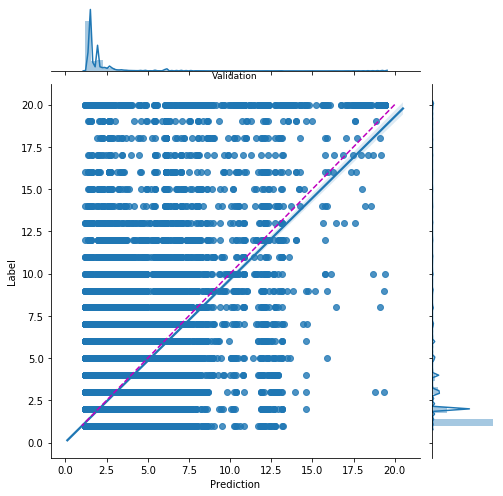

In [88]:
model_performance_sc_plot(rf_val_pred, Y_validation, 'Validation')

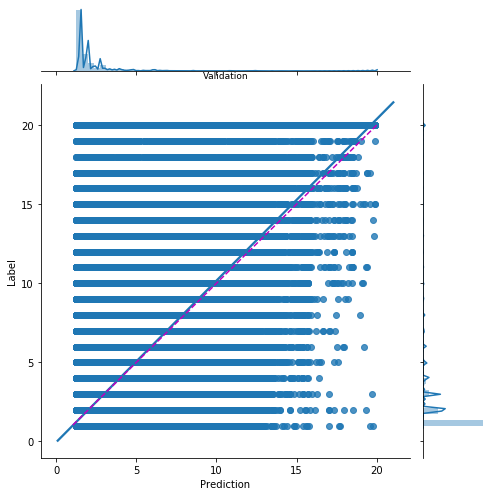

In [89]:
model_performance_sc_plot(rf_train_pred, Y_train, 'Validation')

In [90]:
len(rf_test_pred)

214200

In [91]:
rf_test_pred

array([1.58968068, 1.63762638, 1.58968068, ..., 1.21206214, 1.90873069,
       1.21206214])

In [92]:
df_prediction=pd.DataFrame(rf_test_pred)

In [93]:
df_reset=df_prediction.reset_index()
df_reset.columns=['ID','item_cnt_month']
df_reset

,ID,item_cnt_month
0,0,1.589681
1,1,1.637626
2,2,1.589681
3,3,1.516759
4,4,6.114464
...,...,...
214195,214195,1.212062
214196,214196,1.637626
214197,214197,1.212062
214198,214198,1.908731


In [94]:
df_reset.to_csv('submission.csv')